# Single model

Это модель нейронной сети, в которую по очереди загружаются чанки с данными. Главная проблема - это совместимость по фичам. Решается она при помощи генерации общего списка фичей и промежуточного датафрейма в который вписываются все фичи которые есть в чанке, а все недостающие фичи заполняются нулями, потому что такие значения признаков просто не встречались в текущем чанке.

In [1]:
import os
import gc
import itertools
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Подготовим классы из pytorch:

In [3]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]
    
    
class ClassificationNet(nn.Module):
    def __init__(self, in_feature):
        super().__init__()
        
        self.hidden1 = nn.Linear(in_feature, 256)
        self.f1 = nn.Sigmoid()
        self.hidden2 = nn.Linear(256, 10)
        self.f2 = nn.Sigmoid()
        self.output = nn.Linear(10, 1)
        self.f3 = nn.Sigmoid()
        
    def forward(self, x):
        x = self.f1(self.hidden1(x))
        x = self.f2(self.hidden2(x))
        x = self.f3(self.output(x))
        
        return x

In [4]:
start = datetime.now()

Прочитаем подготовленные чанки с данными:

In [5]:
path_to_dataset = 'data/processed_data/train'

dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset) 
                        if filename.startswith('processed_chunk')])

frames = []

for step, chunk_path in enumerate(dataset_paths):
    print(f'{step}. chunk_path {chunk_path}')
    frames.append(pd.read_parquet(chunk_path, columns=None))

df = pd.concat(frames, axis=0).fillna(0.)
total_features = df.columns
del df, frames
gc.collect()

0. chunk_path data/processed_data/train/processed_chunk_000.parquet
1. chunk_path data/processed_data/train/processed_chunk_001.parquet
2. chunk_path data/processed_data/train/processed_chunk_002.parquet
3. chunk_path data/processed_data/train/processed_chunk_003.parquet
4. chunk_path data/processed_data/train/processed_chunk_004.parquet
5. chunk_path data/processed_data/train/processed_chunk_005.parquet
6. chunk_path data/processed_data/train/processed_chunk_006.parquet
7. chunk_path data/processed_data/train/processed_chunk_007.parquet
8. chunk_path data/processed_data/train/processed_chunk_008.parquet
9. chunk_path data/processed_data/train/processed_chunk_009.parquet
10. chunk_path data/processed_data/train/processed_chunk_010.parquet
11. chunk_path data/processed_data/train/processed_chunk_011.parquet


0

In [6]:
#выбираем девайс на котором будет обучаться модель
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#задаем параметры
num_epochs = 10
batch_size = 1024
learning_rate = 0.0001

#объявляем модель перед загрузкой чанков
model = ClassificationNet(in_feature=len(total_features)-2)
model.to(device)
print(model)

#объявляем оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#объявляем списки метрик
loss_test = []
roc_auc_test = []

ClassificationNet(
  (hidden1): Linear(in_features=360, out_features=256, bias=True)
  (f1): Sigmoid()
  (hidden2): Linear(in_features=256, out_features=10, bias=True)
  (f2): Sigmoid()
  (output): Linear(in_features=10, out_features=1, bias=True)
  (f3): Sigmoid()
)


Обучим модель с учетом весов классов:

In [7]:
chunk_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('processed')])

for chunk_path in chunk_paths:
    #загружаем чанк
    print(f'Loading data: {chunk_path}')
    data = pd.DataFrame(pd.read_parquet(chunk_path), 
                        columns=list(total_features)).fillna(0.)

    #разделяем на трейн и тест
    X = data.drop(['id', 'flag'], axis=1).to_numpy()
    y = data['flag'].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=12, stratify=y)
    del data

    #считаем веса классов
    class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                      classes=np.unique(y_train), 
                                                      y=y_train)
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    #объявляем датасет
    train_dataset = MyDataset(X_train, y_train)
    X_test_tensor = torch.from_numpy(X_test.astype(np.float32)).to(device)
    y_test_tensor = torch.from_numpy(y_test.astype(np.float32)).to(device)

    #объявляем даталоадер
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            weights = torch.zeros_like(y.unsqueeze(-1))
            weights[y==0] = class_weights[0]
            weights[y==1] = class_weights[1]
            loss = F.binary_cross_entropy(pred, y.unsqueeze(-1), weight=weights)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            weights = torch.zeros_like(y_test_tensor.unsqueeze(-1))
            weights[y_test_tensor==0] = class_weights[0]
            weights[y_test_tensor==1] = class_weights[1]
            loss = F.binary_cross_entropy(model(X_test_tensor), y_test_tensor.unsqueeze(-1), weight=weights).item()
            fpr, tpr, _ = roc_curve(y_test, model(X_test_tensor).cpu().detach().numpy().ravel())
            roc_auc = auc(fpr, tpr)
            loss_test.append(loss)
            roc_auc_test.append(roc_auc)
            print(f'epoch {epoch + 1:3.0f} | loss {loss:0.5f} | roc_auc {roc_auc:0.5f}')
            
    print()

Loading data: data/processed_data/train/processed_chunk_000.parquet
epoch   1 | loss 0.68022 | roc_auc 0.68064
epoch   2 | loss 0.65731 | roc_auc 0.71483
epoch   3 | loss 0.63974 | roc_auc 0.72101
epoch   4 | loss 0.62897 | roc_auc 0.72536
epoch   5 | loss 0.62213 | roc_auc 0.72868
epoch   6 | loss 0.61738 | roc_auc 0.73163
epoch   7 | loss 0.61371 | roc_auc 0.73464
epoch   8 | loss 0.61060 | roc_auc 0.73780
epoch   9 | loss 0.60785 | roc_auc 0.74065
epoch  10 | loss 0.60542 | roc_auc 0.74310

Loading data: data/processed_data/train/processed_chunk_001.parquet
epoch   1 | loss 0.60834 | roc_auc 0.73875
epoch   2 | loss 0.60666 | roc_auc 0.74022
epoch   3 | loss 0.60519 | roc_auc 0.74145
epoch   4 | loss 0.60384 | roc_auc 0.74264
epoch   5 | loss 0.60260 | roc_auc 0.74376
epoch   6 | loss 0.60144 | roc_auc 0.74481
epoch   7 | loss 0.60037 | roc_auc 0.74579
epoch   8 | loss 0.59937 | roc_auc 0.74668
epoch   9 | loss 0.59844 | roc_auc 0.74753
epoch  10 | loss 0.59757 | roc_auc 0.74833

Lo

Сохраним модель в файл:

In [8]:
torch.save(model, 'data/single_models/model_state_dict.pth')

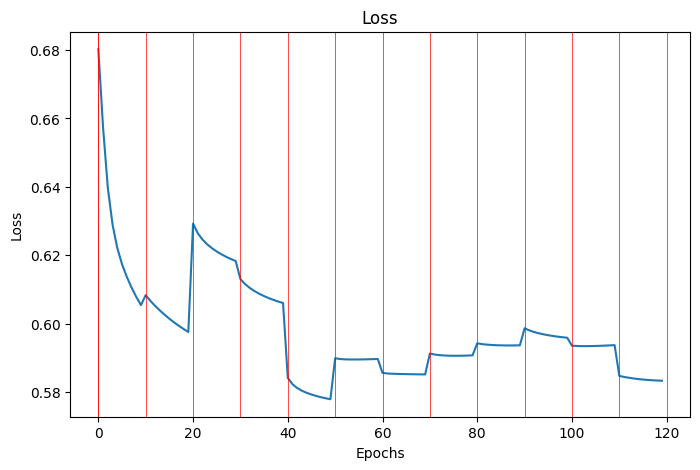

In [9]:
step = np.arange(0, num_epochs*len(chunk_paths))
epochs = [x*10 for x in range(len(chunk_paths) + 1)]

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_test))

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.axvline(x=0, c='red', linewidth=0.5)
for e in epochs:
    plt.axvline(x=e, c='red', linewidth=0.5)
plt.savefig('pictures/Single_model_1.png', bbox_inches='tight');

**Из-за неоднородности данных мы видим скачки при переходе между чанками, но в целом ошибка уменьшается.**

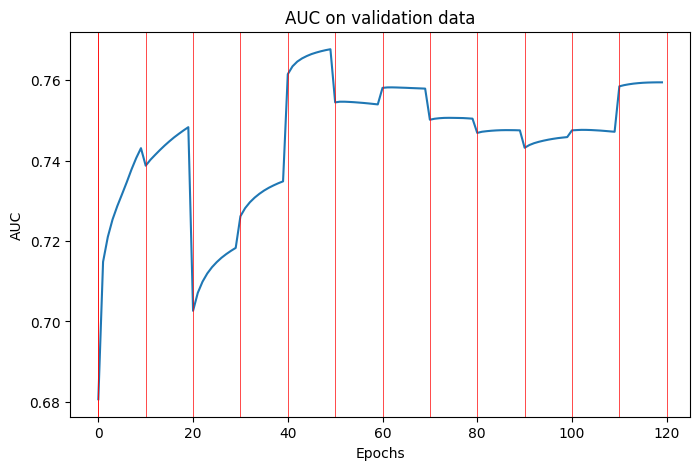

In [10]:
step = np.arange(0, num_epochs*len(chunk_paths))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(roc_auc_test))

plt.title('AUC on validation data')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.axvline(x=0, c='red', linewidth=0.5)
for e in epochs:
    plt.axvline(x=e, c='red', linewidth=0.5)
plt.savefig('pictures/Single_model_2.png', bbox_inches='tight')

**Аналогично метрика auc на тестовом тензоре растет скачками, но в целом улучшается.**

In [11]:
# Выберем предварительно подготовленный тестовый датасет, который не участвовал в обучении до этого
data = pd.DataFrame(pd.read_parquet('data/processed_data/test/test.parquet').head(100000), 
                    columns=list(total_features)).fillna(0.)
data.head()

,id,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,...,pre_loans530_8,pre_loans530_9,pre_loans_total_overdue_1,pre_loans_max_overdue_sum_1,pre_loans3060_1,pre_loans3060_3,pre_loans3060_4,pre_loans6090_1,pre_loans5_10,pre_loans530_17
42594,42594,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168419,168419,1.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58629,58629,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
222749,222749,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90249,90249,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
X_test = data.drop(['id', 'flag'], axis=1)
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))

In [13]:
model = torch.load('data/single_models/model_state_dict.pth')
model.eval()

ClassificationNet(
  (hidden1): Linear(in_features=360, out_features=256, bias=True)
  (f1): Sigmoid()
  (hidden2): Linear(in_features=256, out_features=10, bias=True)
  (f2): Sigmoid()
  (output): Linear(in_features=10, out_features=1, bias=True)
  (f3): Sigmoid()
)

In [14]:
y_test = data['flag']
y_pred = np.round(model(X_test_tensor).cpu().detach().numpy().ravel())

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.62      0.76     96811
           1       0.06      0.77      0.12      3189

    accuracy                           0.62    100000
   macro avg       0.53      0.70      0.44    100000
weighted avg       0.96      0.62      0.74    100000



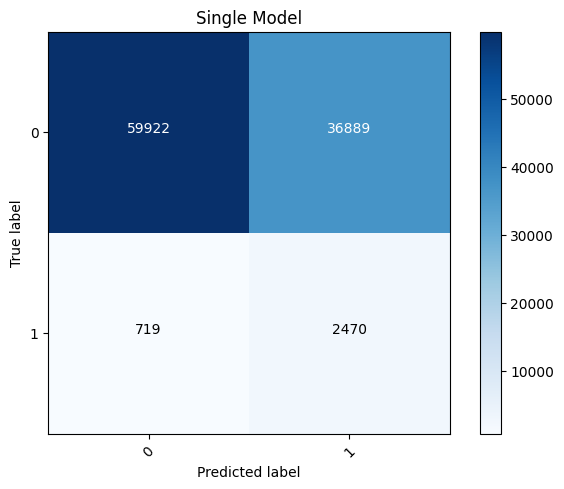

In [16]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['0','1'],
                      title='Single Model')
plt.savefig('pictures/Single_model_3.png', bbox_inches='tight');

**Модель хорошо помечает положительные классы, так что на каждого пропущенного мошенника приходится в среднем 3.2 верно определенных мошенников. При этом модель ошибается на отрицательном классе, но это допустимо в задачах банкинга.**

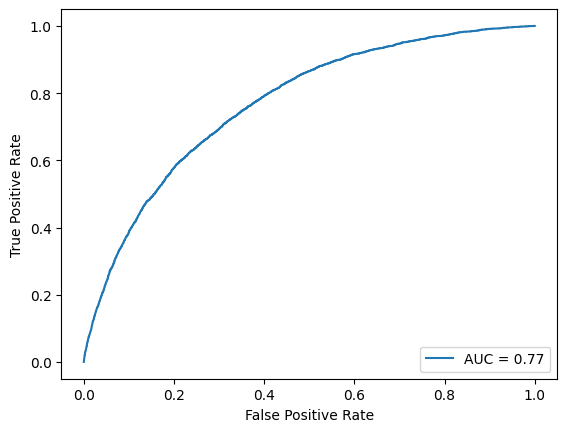

In [17]:
y_pred_proba = model(X_test_tensor).cpu().detach().numpy().ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.savefig('pictures/Single_model_4.png', bbox_inches='tight');

**Значение метрики auc получилось выше целевого, что можно взять за основу в продакшене.**

# Результаты

Сохраним лучшие результаты в таблицу scores:

In [18]:
# Запишем результаты метрики на отложенной выборке в сводную таблицу
df_scores = pd.read_csv('data/scores.csv')
df_scores.loc[df_scores['model'] == 'Single', 'score'] = roc_auc

time = datetime.now() - start
df_scores.loc[df_scores['model'] == 'Single', 'time'] = int(time.seconds)
df_scores.head()

,model,score,time
0,Single,0.769174,223.0
1,Ensemble,0.774852,475.0
2,Linear,0.732219,602.0
3,CatBoost,0.768903,492.0
4,LightGBM,0.775573,118.0


In [19]:
df_scores.to_csv('data/scores.csv', index=False)